### Covid19 Tweet Sentiment Analysis using Natural Language Processing
https://www.kaggle.com/code/omkarpatil0217/covid19-tweet-sentiment-analysis/notebook

In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


### Preparing

In [3]:
# Processing Libraries

import numpy as np
import pickle
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')

# Data Analysis

import matplotlib.pyplot as plt
import seaborn as sns

# NLP

import nltk
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

# Data Modeling

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, accuracy_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

### loading data

In [37]:
data = "C:/Users/82109/Desktop/2022 재 휘/2022 소모임 LEAP/Kaggle/NLP/Coronavirus Tweets/Coronavirus Tweets.csv"
df = pd.read_csv(data, encoding="ISO-8859-1")
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [38]:
# missing values 확인
df.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

### input이 OriginalTweet, output이 Sentiment. 따라서 유의미한 data만 추출.

In [39]:
df = df[['OriginalTweet', 'Sentiment']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


### Sentiment의 종류 파악

In [40]:
df['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

### Sentiment를 label encoding: 긍정, 부정, 중립 3개로 나뉠 수 있도록 결과값을 통합

In [41]:
# Label Encoding Target Feature

df['Sentiment'] = df['Sentiment'].map({'Extremely Positive':1, 'Extremely Negative':-1, 'Negative':-1, 'Positive':1, 'Neutral': 0 })
df[['Sentiment']]

,Sentiment
0,0
1,1
2,1
3,1
4,-1
...,...
41152,0
41153,-1
41154,1
41155,0


In [42]:
df['Sentiment'].value_counts()

 1    18046
-1    15398
 0     7713
Name: Sentiment, dtype: int64

### Data Cleaning

In [50]:
# Removing Pattern in the Input Text Function

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

# Removing the Twitter Handles (@user)
df['clean_tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')

# Removing Special Characters, Punctuation & Numbers
df['clean_tweet'] = df['clean_tweet'].str.replace("[^a-zA-Z#]", " ")

# Removing Short Words
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: " ".join([w for w in x.split() if len(w) > 3]))

# Creating Tokens out of sentences
tokenized_tweet = df['clean_tweet'].apply(lambda x: x.split())

# Stemming
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda sentence:[stemmer.stem(word) for word in sentence])

# Combining words/Tokens back to sentences

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])
df['clean_tweet'] = tokenized_tweet

df.head()

,OriginalTweet,Sentiment,clean_tweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,http http ghgfzcc http nlzdxno
1,advice Talk to your neighbours family to excha...,1,advic talk your neighbour famili exchang phone...
2,Coronavirus Australia: Woolworths to give elde...,1,coronaviru australia woolworth give elderli di...
3,My food stock is not the only one which is emp...,1,food stock onli which empti pleas panic there ...
4,"Me, ready to go at supermarket during the #COV...",-1,readi supermarket dure #covid outbreak becaus ...


### Word Cloud

In [51]:
def wc(x):
    all_words = ' '.join([sentence for sentence in x])
    wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

### Visualizing Most Frequent Tokens

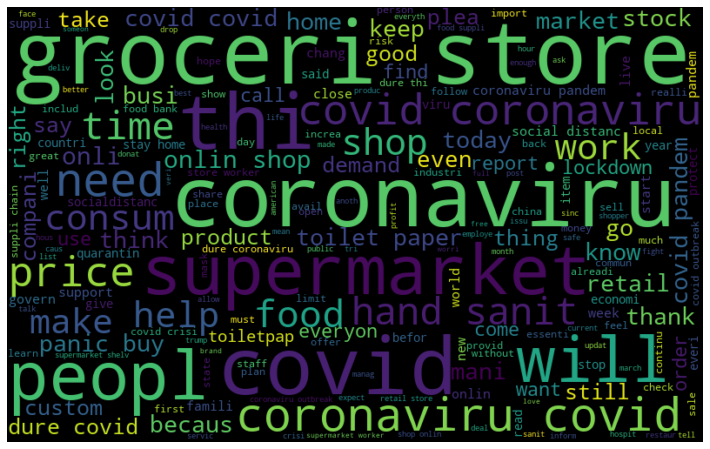

In [52]:
wc(df['clean_tweet'])

### Visualize Most Frequent 'Negative' Tweets Tokens

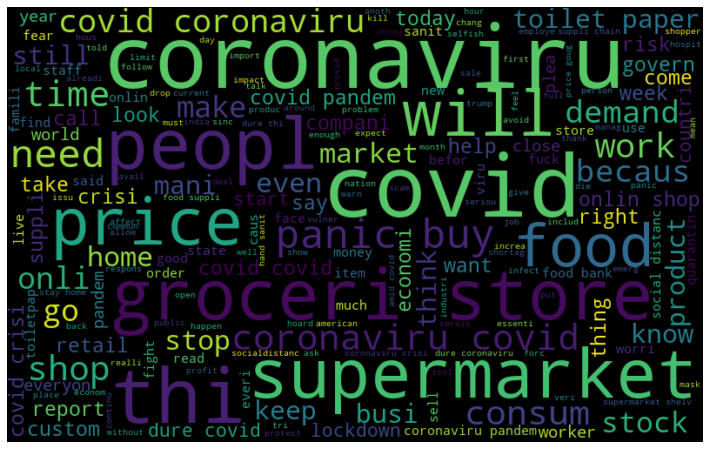

In [55]:
wc(df['clean_tweet'][df['Sentiment'] == -1])

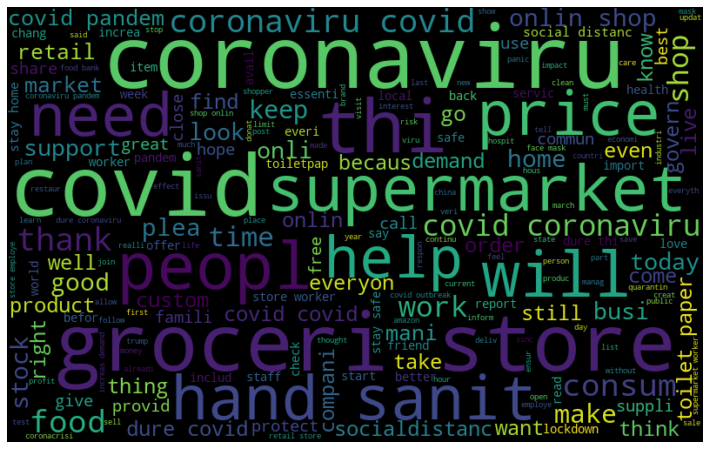

In [56]:
# Visualize Most Frequent Positive Tweets Tokens

wc(df['clean_tweet'][df['Sentiment'] == 1])

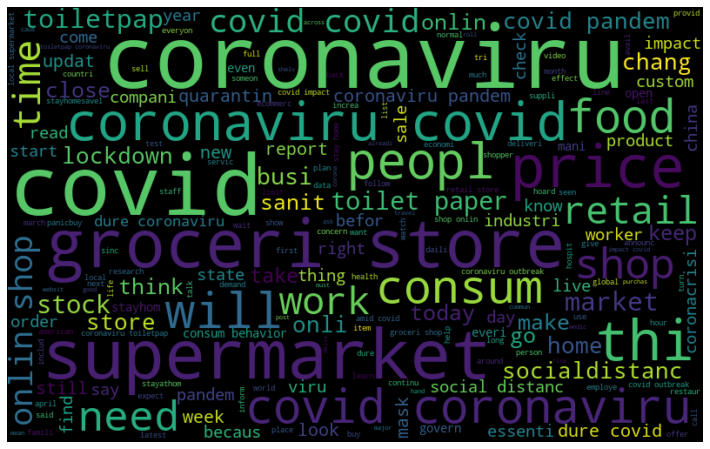

In [57]:
# Visualize Most Frequent Neutral Tweets Tokens

wc(df['clean_tweet'][df['Sentiment'] == 0])

### Top 10 Hashtags

In [58]:
# Extract Hashtag Function

def hashtag_extract(tweets):
    hashtag = []
    for tweet in tweets:
        ht = re.findall(r"#(\w+)", tweet)
        hashtag.append(ht)
    
    return hashtag

In [61]:
# Ploting Function

def plot_hashtags(x):
    
    result = ''
    
    if x == 0:
        y = "Neutral"
    
    elif x == -1:
        y = "Negative"
    
    elif x == 1:
        y = "Positive"
        
    # Extract hashtag from x Tweets

    ht = hashtag_extract(df['clean_tweet'][df['Sentiment']==x])
    ht = sum(ht, [])

    # Top 10 Hashtags

    freq = nltk.FreqDist(ht)
    d = pd.DataFrame({'Hashtag': list(freq.keys()), 'Count': list(freq.values())})
    d = d.nlargest(columns = 'Count', n=10)
    plt.figure(figsize=(15, 8))
    plt.title(f"Top 10 Hashtags for {y} Tweets.")
    sns.barplot(data=d, x="Hashtag", y="Count")
    plt.show()

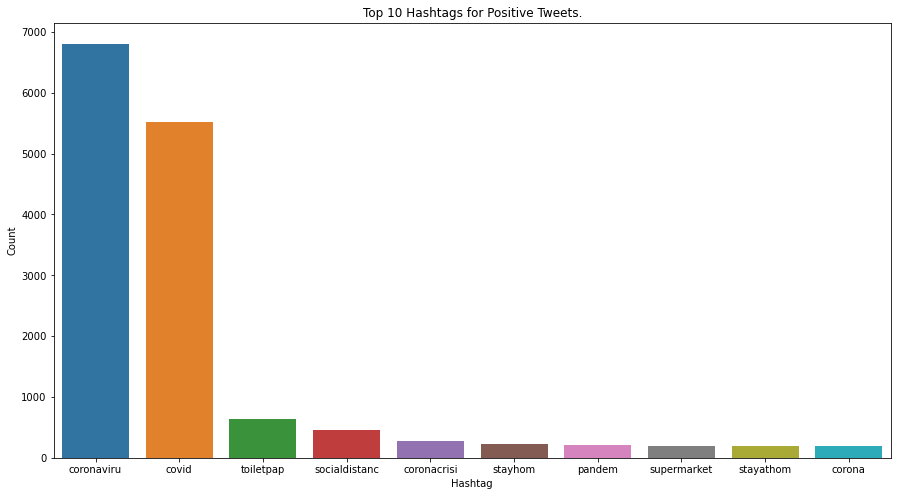

In [62]:
plot_hashtags(1)

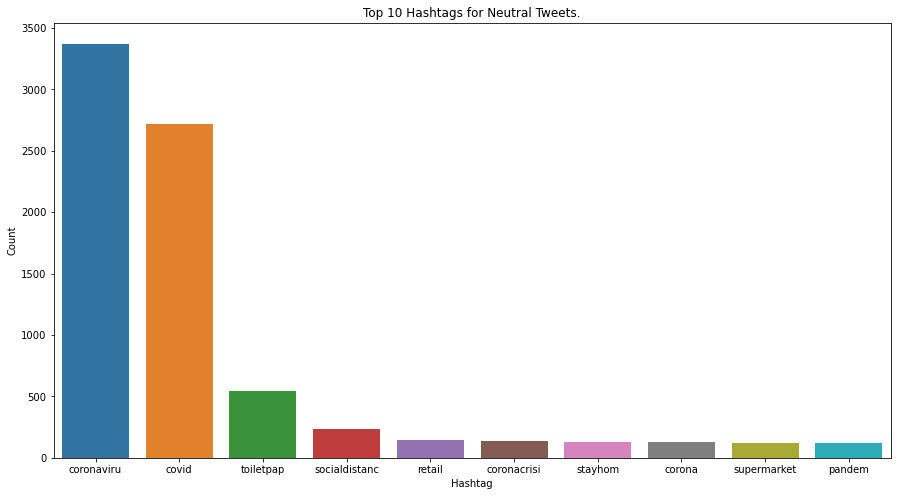

In [64]:
plot_hashtags(0)

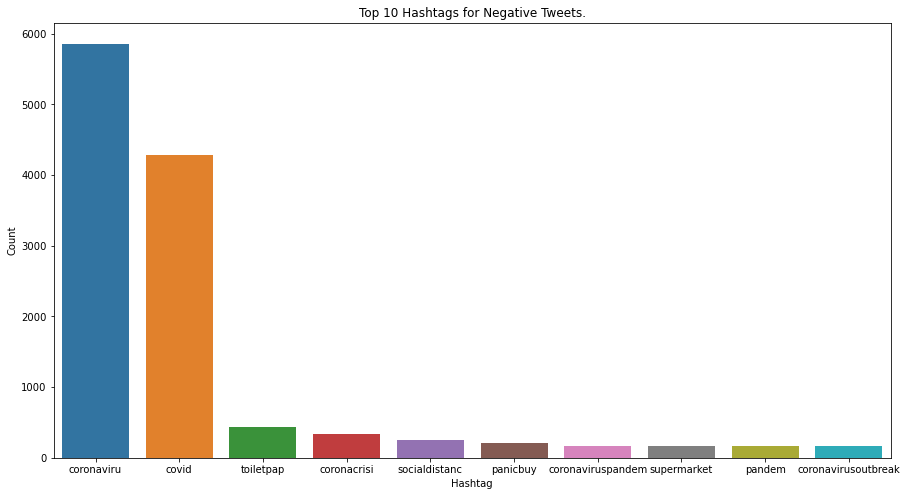

In [65]:
plot_hashtags(-1)

### Data Modeling

In [74]:
# countvectorizer
cv = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
cv = cv.fit_transform(df['clean_tweet'])

In [78]:
print(cv[:2])

  (0, 428)	3
  (1, 14)	1
  (1, 872)	1
  (1, 322)	1
  (1, 626)	2
  (1, 580)	2
  (1, 199)	1
  (1, 171)	1
  (1, 496)	1
  (1, 757)	1
  (1, 279)	1
  (1, 590)	1
  (1, 786)	1
  (1, 4)	1
  (1, 858)	1
  (1, 709)	1
  (1, 597)	1


In [72]:
# train_test_split

X_train, X_test, y_train, y_test = train_test_split(cv, df['Sentiment'], random_state=42, test_size=0.15)

print(X_train)

  (0, 428)	1
  (0, 180)	1
  (0, 395)	2
  (0, 749)	1
  (0, 823)	1
  (0, 953)	1
  (0, 965)	1
  (0, 72)	1
  (0, 834)	1
  (0, 622)	1
  (0, 911)	2
  (0, 24)	1
  (0, 864)	1
  (1, 786)	1
  (1, 298)	1
  (1, 141)	1
  (1, 887)	1
  (1, 558)	1
  (1, 492)	1
  (1, 94)	1
  (1, 425)	1
  (1, 248)	1
  (1, 355)	1
  (1, 393)	1
  (1, 683)	1
  :	:
  (34980, 575)	1
  (34980, 470)	1
  (34980, 201)	1
  (34981, 195)	1
  (34981, 76)	1
  (34981, 842)	1
  (34981, 731)	1
  (34981, 960)	1
  (34981, 101)	1
  (34981, 669)	1
  (34981, 735)	1
  (34981, 998)	1
  (34981, 980)	1
  (34981, 987)	1
  (34981, 889)	1
  (34981, 804)	1
  (34981, 508)	1
  (34981, 139)	1
  (34982, 428)	1
  (34982, 180)	1
  (34982, 195)	1
  (34982, 178)	1
  (34982, 430)	1
  (34982, 902)	1
  (34982, 179)	1


In [80]:
X_train.shape

(34983, 1000)

In [81]:
y_train

36467    1
1347     1
27184    0
13108    1
31543   -1
        ..
6265    -1
11284   -1
38158   -1
860      0
15795   -1
Name: Sentiment, Length: 34983, dtype: int64

In [82]:
# Logistic Regression

lr = LogisticRegression()

lr.fit(X_train, y_train)

y_predicted_train = lr.predict(X_train)
y_predicted_test = lr.predict(X_test)

### Model Evaluation

In [96]:
def evaluation_parametrics(name, y_train, yp_train, y_test, yp_test):
    print(f"\n-----------------------------{name}-----------------------------\n")
    
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0, 0] / (cm_train[0, 0] + cm_train[0,1])), 4)
    
    print("Classification Report for Train Data")
    print()
    print(classification_report(y_train, yp_train))
    print("\n-----------------------------{}-----------------------------\n")
    print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train), 4))
    print("F1-score on Train Data:", round(f1_score(y_train, yp_train, average='weighted'), 4))
    print("--------------------------------------------------------------------------")
    
    cm_test = confusion_matrix(y_test, yp_test)
    t2 = ConfusionMatrixDisplay(cm_test)
    s2 = round((cm_test[0, 0] / (cm_test[0, 0] + cm_test[0, 1])), 4)
    
    print("Classification Report for Test Data")
    print()
    print(classification_report(y_test, yp_test))
    print("\n-----------------------------{}-----------------------------\n")
    print("Specificity on Test Data: ", s2)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
    print("F1-score on Test Data:", round(f1_score(y_test, yp_test, average='weighted'), 4))
    
    t1.plot()
    t2.plot()


-----------------------------Logistic Regression Classifier Result-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

          -1       0.80      0.76      0.78     13092
           0       0.65      0.74      0.69      6537
           1       0.82      0.81      0.81     15354

    accuracy                           0.78     34983
   macro avg       0.76      0.77      0.76     34983
weighted avg       0.78      0.78      0.78     34983


-----------------------------{}-----------------------------

Specificity on Train Data:  0.8867
Accuracy on Train Data:  0.7759
F1-score on Train Data: 0.777
--------------------------------------------------------------------------
Classification Report for Test Data

              precision    recall  f1-score   support

          -1       0.77      0.74      0.76      2306
           0       0.63      0.69      0.66      1176
           1       0.80      0.79      0.80     

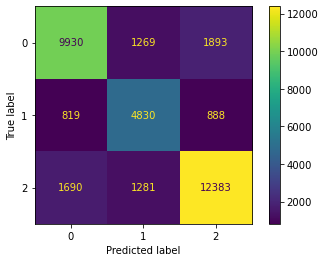

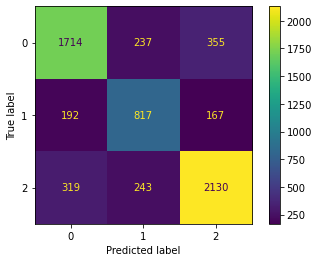

In [97]:
evaluation_parametrics("Logistic Regression Classifier Result", y_train, y_predicted_train, y_test, y_predicted_test)